<a href="https://colab.research.google.com/github/Jayakrishna155/MachineLearning/blob/main/TwitterSentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
#API Fetch the dataset from kaggle
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 96% 78.0M/80.9M [00:00<00:00, 140MB/s]
100% 80.9M/80.9M [00:00<00:00, 118MB/s]


In [ ]:
#etract zip file
from zipfile import  ZipFile
dataset = '/content/sentiment140.zip'

with ZipFile(dataset,'r') as zip:
    zip.extractall()
    print("The dataset is extracted ")

The dataset is extracted 


Import the dependencies

In [ ]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
print("printing stop words in english")
print(stopwords.words('english'))

printing stop words in english
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only',

In [ ]:
#data preprocessing
twitter_dataset = pd.read_csv('/content/training.1600000.processed.noemoticon.csv',encoding='ISO-8859-1')

In [ ]:
#twitter data  no of row ans data
twitter_dataset.shape

(1599999, 6)

In [ ]:
#first 5 rows
twitter_dataset.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [ ]:
#reading dataset again
coulmn_names = ['target','ids','date','flag','user','text']
twitter_dataset = pd.read_csv('/content/training.1600000.processed.noemoticon.csv',names=coulmn_names,encoding='ISO-8859-1')

In [ ]:
twitter_dataset.shape
twitter_dataset.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
twitter_dataset.isnull().sum()

,0
target,0
ids,0
date,0
flag,0
user,0
text,0


In [ ]:
#checking distribution of target columns
twitter_dataset['target'].value_counts()

,count
target,
0,800000
4,800000


In [ ]:
twitter_dataset.replace({'target':{4:1}},inplace=True)

Stemming


In [ ]:
port_stem = PorterStemmer()

In [ ]:
def stemming(content):
  stemmed_content = re.sub('[^a-zA-Z]',' ',content)
  stemmed_content = stemmed_content.lower()
  stemmed_content = stemmed_content.split()
  stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
  stemmed_content = ' '.join(stemmed_content)
  return stemmed_content

In [ ]:
twitter_dataset['stemmed_content'] = twitter_dataset['text'].apply(stemming)

In [ ]:
#seperating data and label
X=twitter_dataset['stemmed_content'].values
Y=twitter_dataset['target'].values

In [ ]:
print(X,Y)

['switchfoot http twitpic com zl awww bummer shoulda got david carr third day'
 'upset updat facebook text might cri result school today also blah'
 'kenichan dive mani time ball manag save rest go bound' ...
 'readi mojo makeov ask detail'
 'happi th birthday boo alll time tupac amaru shakur'
 'happi charitytuesday thenspcc sparkschar speakinguph h'] [0 0 0 ... 1 1 1]


Spliting the data into test and train

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,stratify=Y,random_state=2)

In [ ]:
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(1280000,) (320000,) (1280000,) (320000,)


In [ ]:
#converting textual data to numerical data
vectorizer = TfidfVectorizer()
vectorizer.fit(x_train)
x_train = vectorizer.transform(x_train)
x_test = vectorizer.transform(x_test)

In [ ]:
print(x_train)

  (0, 109306)	0.3753708587402299
  (0, 185193)	0.5277679060576009
  (0, 235045)	0.41996827700291095
  (0, 354543)	0.3588091611460021
  (0, 436713)	0.27259876264838384
  (0, 443066)	0.4484755317023172
  (1, 160636)	1.0
  (2, 77929)	0.3128408075034635
  (2, 109306)	0.45911764137283173
  (2, 124484)	0.18921559608014152
  (2, 129411)	0.2907419272795715
  (2, 132311)	0.20289715703997943
  (2, 150715)	0.1880385058320795
  (2, 178061)	0.1619010109445149
  (2, 266729)	0.24123230668976978
  (2, 288470)	0.16786949597862735
  (2, 406399)	0.32105459490875526
  (2, 407301)	0.18709338684973034
  (2, 409143)	0.15169282335109838
  (2, 433560)	0.32965958980285653
  (2, 443430)	0.33485996702528453
  (3, 56476)	0.5200465453608686
  (3, 151770)	0.278559647704793
  (3, 158711)	0.4456939372299574
  (3, 172421)	0.37464146922154384
  :	:
  (1279996, 291078)	0.17981734369155505
  (1279996, 318303)	0.21254698865277744
  (1279996, 373144)	0.35212500999832036
  (1279996, 390130)	0.2206474219107611
  (1279996, 412

Training the machine learning model using logistic regression

In [ ]:
model = LogisticRegression(max_iter=1000)

In [ ]:
model.fit(x_train,y_train)

LogisticRegression(max_iter=1000)

Model evaluation

In [ ]:
x_train_prediction = model.predict(x_train)
training_data_accuracy = accuracy_score(x_train_prediction,y_train)

Accuracy on training data :  0.79871953125
Accuracy on Testing data :  0.77668125


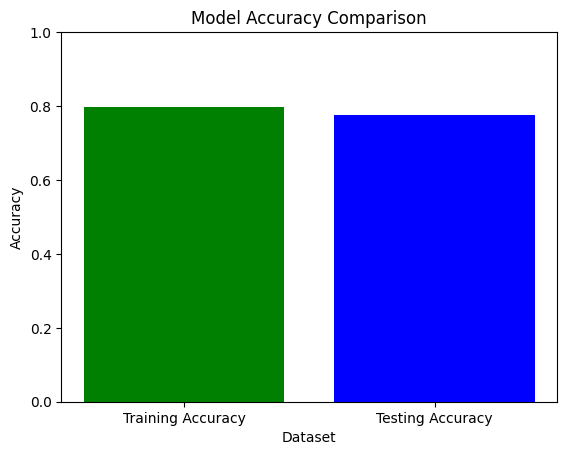

In [ ]:
#accuracy of the test data
x_test_prediction = model.predict(x_test)
testing_data_accuracy = accuracy_score(x_test_prediction,y_test)
print('Accuracy on training data : ',training_data_accuracy)
print('Accuracy on Testing data : ',testing_data_accuracy)
accuracies = [training_data_accuracy, testing_data_accuracy]
labels = ['Training Accuracy', 'Testing Accuracy']

plt.bar(labels, accuracies, color=['green', 'blue'])
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)  # Set the range from 0 to 1 for accuracy
plt.show()

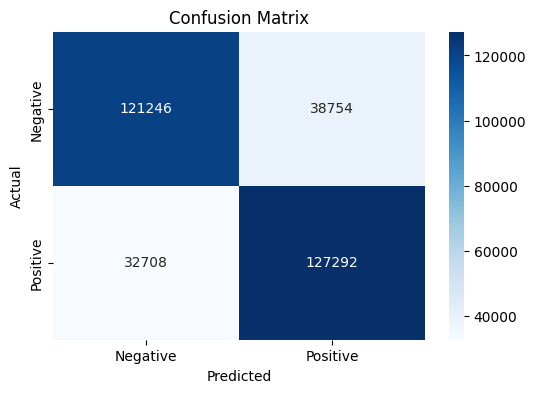

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming model is already trained and test data is available
y_pred = model.predict(x_test)
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


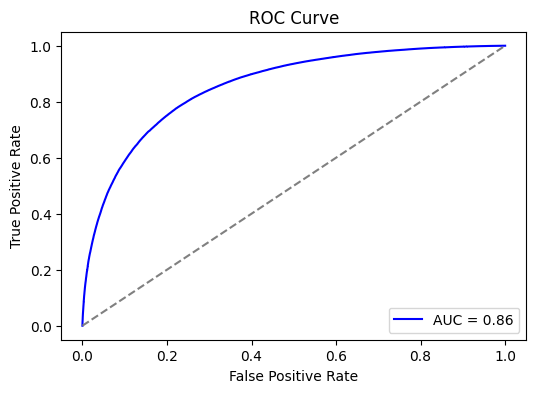

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get probabilities for positive class
y_prob = model.predict_proba(x_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc_score(y_test, y_prob):.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line representing random predictions
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


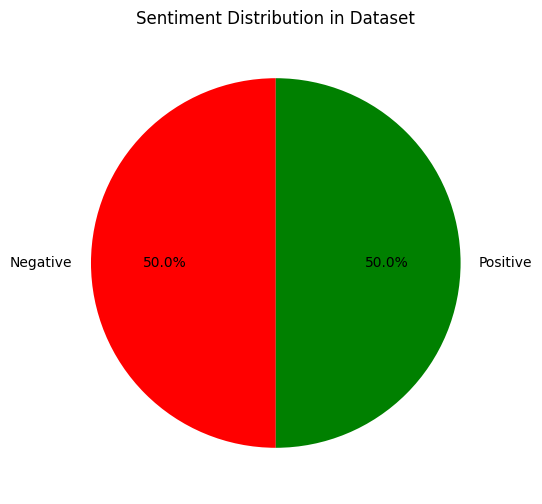

In [ ]:
sentiment_counts = twitter_dataset['target'].value_counts()

# Plotting pie chart for sentiment distribution
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=['Negative', 'Positive'], autopct='%1.1f%%', startangle=90, colors=['red', 'green'])
plt.title('Sentiment Distribution in Dataset')
plt.show()


Saving the trained  model

In [ ]:
# Save the model and vectorizer
import pickle

with open('vectorizer.pkl', 'wb') as vec_file:
    pickle.dump(vectorizer, vec_file)

with open('sentiment_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)


Using the saved model for future prediction

In [ ]:
# Load the vectorizer and model
with open('vectorizer.pkl', 'rb') as vec_file:
    loaded_vectorizer = pickle.load(vec_file)

with open('sentiment_model.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)


In [ ]:
X_new = x_test[201]
prediction = loaded_model.predict(X_new)
print(prediction)
if(prediction[0]==0):
  print('Negative')
else:
  print('Positive')

[0]
Negative


In [ ]:
def predict_sentiment_with_emoji(comment, vectorizer, model):
    processed_comment = vectorizer.transform([comment])  # Transform the input text
    prediction = model.predict(processed_comment)
    sentiment = "😊 Positive" if prediction[0] == 1 else "😔 Negative"
    return sentiment


In [ ]:
new_comment = input("Enter a comment: ")
sentiment = predict_sentiment_with_emoji(new_comment, loaded_vectorizer, loaded_model)
print(f"The sentiment of the comment is: {sentiment}")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')